In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import copy
import csv
import decimal
import json
import os
import pickle
import typing
from collections import Counter, defaultdict
from copy import deepcopy
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Set, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image as pil_img
import seaborn as sns
import simdjson as json
from IPython.display import display
from PIL import Image

# If you are using normal pycocotools you will need to comment out these three lines and replace with just: from pycocotools.coco import COCO
from pycocotools.coco import COCO, Ann, Cat, Image, Ref
from pycocotools.helpers import CocoClassDistHelper, CocoJsonBuilder
from pycocotools.helpers.coco_builder import COCOShrinker
from tqdm.auto import tqdm

/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pathlib import Path

from pycocotools.coco import COCO

VALID_SPLITS = {
    # "R-refcoco": ["unc"],
    # "R-refcoco+": ["unc"],
    # "R-refcocog": ["umd"],
    # "refclef": ["berkeley", "unc"],
    "refcoco": ["unc", "google"],
    "refcoco+": ["unc"],
    "refcocog": [
        "umd",
        "google",
    ],  # ["google", "umd"], # google and umd are identical, but have differet train/val/test splits.
    # "coconegref": ["berkeley"],
    "fprefcoco_v002": ["berkeley", "unc", "google"],
    "fprefcoco+_v002": ["berkeley", "unc"],
    "fprefcocog_v002": ["berkeley", "umd", "google", "umd"],
}


def build_refcoco(refseg_path: Path, dataset_name: str, split_by: str = None) -> COCO:
    assert dataset_name in VALID_SPLITS, dataset_name
    if split_by is None:
        split_by = VALID_SPLITS[dataset_name][0]
    else:
        assert (
            split_by.replace("_enhanced", "").replace("_exclude_unified", "")
            in VALID_SPLITS[dataset_name]
        ), f"Did you mean split_by={VALID_SPLITS[dataset_name]}"
    coco = COCO(
        refseg_path / dataset_name / "instances.json",
        is_ref_dataset=True,
        dataset_name=dataset_name,
        split_by=split_by,
    )
    return coco


IMG_DIR = Path("/shared/gbiamby/data/coco/train2014")
REFSEG_DIR = Path("/shared/gbiamby/data/refer_seg")
# REFSEG_DIR = Path("output/ref_seg")
refcoco = build_refcoco(REFSEG_DIR, "fprefcoco+_v002", "berkeley_exclude_unified")

Loading refs from '/shared/gbiamby/data/refer_seg/fprefcoco+_v002/refs(berkeley_exclude_unified).p'
Loaded 49856 refs
loading annotations into memory...
Done (t=2.89s)
creating index...
index created!


In [43]:
# import spacy


# def get_sentence_lookup(refcoco: COCO, search_sent: str):
#     sent_lookup = {}
#     counter = Counter()
#     for image_id, refs in refcoco.img_to_refs.items():
#         for ref in refs:
#             # if image_id == 376848:
#             #     print(f"Found ref with {len(ref['sentences'])} sentences")
#             counter.update({len(ref["sentences"]): 1})
#             for sent_idx, sent in enumerate(ref["sentences"]):
#                 sent_lookup[(image_id, ref["ref_id"], sent_idx)] = sent
#                 for k, v in sent.items():
#                     if isinstance(v, spacy.tokens.Doc):
#                         print("Found Doc1: ", k)
#                         return
#                     if isinstance(v, list) and len(v) > 0:
#                         if isinstance(v[0], spacy.tokens.Doc):
#                             print("Found Doc2: ", k)
#                             return
#                 # if image_id == 376848 and sent["sent"] == search_sent:
#                 #     print("sent: ", sent["sent"])
#                 #     print("ref: ", [s["sent"] for s in ref["sentences"]])
#                 #     print("image: ", image_id)
#     print(counter)
#     return sent_lookup


# print("ds: ", ds)
# refcoco = build_refcoco(REFSEG_DIR, "fprefcocog_v002", "berkeley_exclude_unified")
# lookup = get_sentence_lookup(refcoco, "lady in blue")

ds:  fprefcocog_v002
Loading refs from '/shared/gbiamby/data/refer_seg/fprefcocog_v002/refs(berkeley_exclude_unified).p'
Loaded 49822 refs
loading annotations into memory...
Done (t=1.15s)
creating index...
index created!
Counter({4: 42111, 2: 5070, 3: 2319, 1: 243, 6: 71, 5: 8})


In [42]:
# def fix_refg(refcoco: COCO):
#     print("dataset name: ", refcoco.dataset_name)
#     refs_path = REFSEG_DIR / "fprefcocog_v002/refs(berkeley_exclude_unified).p"
#     assert refs_path.exists()

#     refs_data = refcoco.refs_data
#     for ref in refs_data:
#         for sent in ref["sentences"]:
#             if "spcy_ENTS" not in sent:
#                 continue
#             ents = sent["spcy_ENTS"]
#             if len(ents) < 1:
#                 continue
#             ents = [str(ent).strip() for ent in ents]
#             sent["spcy_ENTS"] = ents
#     with open(refs_path, "wb") as file:
#         pickle.dump(refs_data, file)


# fix_refg(refcoco)

dataset name:  fprefcocog_v002


In [240]:
def show_coco_image(image_id: int, refcoco: COCO):
    for ref in refcoco.img_to_refs[image_id]:
        print(f"ref_id: {ref['ref_id']}, split: {ref['split']}")
        refcoco.showRef(ref)
        plt.show()
        plt.close()


# show_coco_image(376848, refcoco)

---

## Show CLAIR scores

In [538]:
def get_clair_results_df(preds_path: Path):
    with open(preds_path, "r") as json_file:
        raw_data = json.load(json_file)
    results = []
    for idx, r in enumerate(raw_data):
        # if idx == 0:
        #     print(r.keys())

        result = deepcopy(r)
        result["sentence"] = result["sent"]["sent"]
        if result["gt_exist"]:
            result["gt_sentence"] = ""
            result["change_type"] = None
        else:
            result["gt_sentence"] = result["sent"]["gt_sent"]
            result["change_type"] = result["sent"]["change_type"]

        del result["ref_gt_sents"]
        del result["img_gt_sents"]
        del result["sent"]
        result["ref_gt_sents"] = [s["sent"] for s in r["ref_gt_sents"]]
        result["img_gt_sents"] = [s["sent"] for s in r["img_gt_sents"]]
        results.append(result)
    print("num results: ", len(raw_data))
    df = pd.DataFrame(results)

    return df


clair_results_paths = [
    # "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores/fprefcocog|berkeley_exclude_unified|val-clair_scores.json",
    # "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_phrase_match/fprefcocog|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    # "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_no_api/fprefcocog|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    # # Hollistic (ours):
    # "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_001/fprefcoco|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    # "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_001/fprefcoco+|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    # "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_001/fprefcocog|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    # LLAVA + LISA (ours):
    "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_cascading_002/fprefcoco|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_cascading_002/fprefcoco+|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
    "/home/gbiamby/proj/geo-llm-ret/lib/clair/output/clair_scores_cascading_002/fprefcocog|berkeley_exclude_unified|val-clair_scores-model_gpt-4-turbo.json",
]
dfs = []
for p in clair_results_paths:
    ds_name = Path(p).stem.split("|")[0]
    print("loading clair results for ", ds_name)
    df = get_clair_results_df(p)
    df.insert(0, "ds", ds_name)
    dfs.append(df)
df = pd.concat(dfs)

# Done, show preview:
print("num preds loaded: ", len(df))
pd.options.display.float_format = "{:,.2f}".format
pd.set_option("display.max_colwidth", None)
df.head(3)

loading clair results for  fprefcoco
num results:  21094
loading clair results for  fprefcoco+
num results:  20962
loading clair results for  fprefcocog
num results:  9554
num preds loaded:  51610


,ds,clair_candidates,clair_reason,clair_reference_set,clair_score,conversation,gt_exist,image_id,pred_exist,pred_sent,ref_id,ref_split,sent_idx,sentence,gt_sentence,change_type,ref_gt_sents,img_gt_sents
0,fprefcoco,[],,[],NaN,Analyze the image and verify if there are any referred objects in the image. Yes or no with explanations. Here's an example.,True,376848,True,"Yes, there is a person furthest to the right in the image.",17816,val,0,person furthest to the right,,None,"[person in blue shirt, person left]","[person furthest to the right, boy in orange, person on right, person in blue shirt, person left]"
1,fprefcoco,[],,[],NaN,Analyze the image and verify if there are any referred objects in the image. Yes or no with explanations. Here's an example.,True,376848,False,"No, there is no boy in orange in the image. The image features a man and a woman sitting at a wooden dining table with a Scrabble game, wine glasses, and a box of cookies.",17816,val,1,boy in orange,,None,"[person in blue shirt, person left]","[person furthest to the right, boy in orange, person on right, person in blue shirt, person left]"
2,fprefcoco,[],,[],NaN,Analyze the image and verify if there are any referred objects in the image. Yes or no with explanations. Here's an example.,True,376848,True,"Yes, there is a person on the right in the image.",17816,val,2,person on right,,None,"[person in blue shirt, person left]","[person furthest to the right, boy in orange, person on right, person in blue shirt, person left]"


---
# Load Results and Compute Scores

In [471]:
PARSE_ERR_WHITELIST = set(
    [
        "NAN-no, this picture doesn't seem to have .",
        "NAN-the image lacks .",
        "NAN-no, this picture doesn't have it.",
        "NAN-no, this picture doesn't have ." "NAN-no, this depiction is devoid of .",
        "NAN-no, this depiction is devoid of .",
        "NAN-no evidence of it in this visual.",
        "NAN-no evidence of in this visual.",
        "NAN-no in sight in this frame.",
        "NAN-no, the image doesn't include it.",
        "NAN-no in sight in this frame.",
        "NAN-no, there's no in this image.",
        "NAN-i don't see it in the image.",
        "NAN-no, there's no in this image.",
        "NAN-i'm not able to spot it here.",
        "NAN-no, the image doesn't include .",
        "NAN-i don't see in the image.",
        "NAN-this image seems to be missing it.",
        "NAN-no in sight in this frame.",
        # llava
        "NAN-no, there are no in the image.",
        """NAN-no, there is no in the image.""",
        "NAN-no, this picture doesn't seem to have it.",
        "NAN-no, there's no in this picture.",
        "NAN-i'm not able to spot here.",
        "NAN-no, this picture doesn't seem to have any .",
        "NAN-no sign of in the image.",
        "NAN-the image doesn't feature .	",
        "NAN-i can't find in this image.",
        "NAN-no, this picture doesn't seem to have segment .",
        "NAN-no, this picture doesn't have .",
        "NAN-no, this picture doesn't seem to have in it.",
        "NAN-this image is devoid of any .",
        "NAN-no evidence of it found.",
        "",
        "",
        "",
    ]
)
PARSE_ERR_WHITELIST = {e.strip() for e in PARSE_ERR_WHITELIST}

In [539]:
import regex as re


def check_match(pattern: str, pred_sent: str):
    if re.match(pattern, pred_sent):
        result = re.match(pattern, pred_sent, flags=re.IGNORECASE)
        return True, result
    return (False, None)


def scrub_lisa_pred_for_clair_scoring(row):
    pred_sent = row["pred_sent"].replace(row["sentence"], "").lower()
    patterns = [
        ".*?(however[,]{0,1})(?P<pred_correction>.*?)\\s*(is present)",
        "no.*?(but the image does have){1,1}(?P<pred_correction>.*)(in there){0,1}[\\s\\.]{0,1}$",
        "no.*?(but take a look at the|but take a look at){1,1}(?P<pred_correction>.*)(in there)",
        "(the).*?(isn't in this image, but|in sight, but|but do take note of|is missing, but you'll notice)(?P<pred_correction>.*?)(is){0,1}[\\s\\.]{0,1}$",
        "(no|the).*?(but do take note of|found, but you can see){1,1}(?P<pred_correction>.*)",
        "(no)[,\\s]*.*?(in sight, but|in sight)(?P<pred_correction>.*)is noticeable[\\s\\.]{0,1}",
        ".*?(isn't in the picture, instead, it's)(?P<pred_correction>.*)",
        ".*?(isn't in the shot, but|but the image does feature)(?P<pred_correction>.*?)(is){0,1}[\\s\\.]{0,1}$",
        "no sign of.*?(but)(?P<pred_correction>.*?)(can be see instead){0,1}[\\s\\.]{0,1}$",
        "no evidence of.*?(but don't miss|but check out the|but check out)(?P<pred_correction>.*?)(instead){0,1}[\\s\\.]{0,1}$",
        "no trace of.*?(but don't miss)(?P<pred_correction>.*?)(in the same image){0,1}[\\s\\.]{0,1}$",
        "no.*?(but you can see a|but take )(?P<pred_correction>.*?)(in the same image){0,1}[\\s\\.]{0,1}$",
        "i don't see.*?(but)(?P<pred_correction>.*?)(is present|is prominently displayed)[\\s\\.]{0,1}$",
        "no.*?(but the image includes|but the|in sight, but|, but a)(?P<pred_correction>.*?)(is there|is in sight|in sight|is present){0,1}[\\s\\.]{0,1}$",
        "the.*?(isn't visible, but|isn't there, but|isn't here, but there's)(?P<pred_correction>.*?)(is present|stands out|in the image|is)[\\s\\.]{0,1}$",
        "the search for.*?(turned up empty, however, you can see)(?P<pred_correction>.*?)(is present){0,1}[\\s\\.]{0,1}$",
        "i can't confirm.*?(but there's|but there is)(?P<pred_correction>.*?)[\\s\\.]{0,1}$",
        "the image lacks.*?(but not|yet showcases)(?P<pred_correction>.*?)[\\s\\.]{0,1}$",
        ".*?(isn't part of the scene, but)(?P<pred_correction>.*?)(is evident)[\\s\\.]{0,1}$",
        ".*?(but)(?P<pred_correction>.*?)(is certainly present)[\\s\\.]{0,1}$",
        ".*?(but there's|but there is|but check out|but the image highlights)(?P<pred_correction>.*?)[\\s\\.]{0,1}$",
        ".*?(but there's|but there is|but check out|but the image highlights|but the image includes|is not present, but|but i do see|but the image clearly shows|however,)(?P<pred_correction>.*?)(is quite evident|is present){0,1}[\\s\\.]{0,1}$",
        ".*?(is absent, but you might be interested in)(?P<pred_correction>.*?)(that's in the picture){0,1}[\\s\\.]{0,1}$",
        ".*?(is not detected, but)(?P<pred_correction>.*?)(is){0,1}[\\s\\.]{0,1}$",
        ".*?(isn't part of this, but)(?P<pred_correction>.*?)(is evident){0,1}[\\s\\.]{0,1}$",
        ".*?(is not in the shot, but take a look at|doesn't appear, but you can see|doesn't feature, but you can see|but it does contain)(?P<pred_correction>.*?)[\\s\\.]{0,1}$",
        ".*?(but can see)(?P<pred_correction>.*?)(is evident|is in the frame){0,1}[\\s\\.]{0,1}$",
    ]
    for idx, pat in enumerate(patterns):
        is_match, match = check_match(pat, pred_sent)
        if is_match:
            if match and match.groupdict() and "pred_correction" in match.groupdict():
                return str(match.groupdict()["pred_correction"]), ""
            else:
                return "", f"ERROR: {match}"
    while "  " in pred_sent:
        pred_sent = pred_sent.replace("  ", " ")
    return "", f"NAN-{pred_sent}".strip()


def adjust_clair_score(row):
    """
    Applies rules such as 'if [SEG] token is predicted, score is zero',
    'If text response just says that object is not found, without a suggested correction, score is 1.0 ', etc.
    """
    if "has_seg_token" in row and row["has_seg_token"]:
        return 0
    elif row["fp_correction"].startswith("NAN-yes"):
        return 0
    elif not (
        row["fp_correction"].startswith("NAN-") or "ERROR" in row["fp_correction"]
    ):
        return row["clair_score"]
    elif (
        row["fp_correction"].startswith("NAN-no")
        or "i don't see" in row["fp_correction"]
        or "missing it" in row["fp_correction"]
        or "image is devoid of" in row["fp_correction"]
        or "image seems to be missing" in row["fp_correction"]
        or "image doesn't feature" in row["fp_correction"]
        or "not able to spot" in row["fp_correction"]
        or "can't find" in row["fp_correction"]
        or "fails to display" in row["fp_correction"]
        or "doesn't seem to feature" in row["fp_correction"]
        or "the image lacks" in row["fp_correction"]
        # or "" in row["fp_correction"]
        # or "" in row["fp_correction"]
    ) and not ("but, " in row["fp_correction"] or "however" in row["fp_correction"]):
        return 1.0
    return None


def get_clair_scores_lisa(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy(deep=True)
    print(f"Processing {len(df)} results")
    print(f"Num pos: {len(df[df.gt_exist])}, num negative: {len(df[~df.gt_exist])}")
    df_fp = df[~df.gt_exist]
    df_fp["has_seg_token"] = df_fp.pred_sent.apply(lambda row: "[SEG]" in row.upper())
    print(
        f"has_seg_token:{len(df_fp[df_fp.has_seg_token])}, NO_seg_token:{len(df_fp[~df_fp.has_seg_token])}"
    )
    df_fp["fp_correction"] = df_fp.apply(
        lambda row: scrub_lisa_pred_for_clair_scoring(row)[0], axis=1
    )
    df_fp["has_fp_correction"] = df_fp.fp_correction.apply(
        lambda c: len(c) > 0 and not c.startswith("NAN-")
    )
    df_fp["is_fp_correction_whitelisted"] = df_fp.fp_correction.apply(
        lambda corr: corr in PARSE_ERR_WHITELIST
    )
    df_fp["clair_score_adj"] = df_fp.apply(lambda row: adjust_clair_score(row), axis=1)
    df_fp["has_final_score"] = df_fp.clair_score_adj.apply(lambda cs: not pd.isna(cs))
    df_fp["has_candidate"] = df_fp.apply(
        lambda row: len(row["clair_candidates"][0]) > 0
        if len(row["clair_candidates"]) > 0
        else False,
        axis=1,
    )
    df_noscore = df_fp[~df_fp.has_final_score]
    df_no_correction = df_fp[
        (~df_fp.fp_correction.isin(PARSE_ERR_WHITELIST)) & (~df_fp.has_seg_token)
    ]
    df_no_correction = df_no_correction[
        df_no_correction.fp_correction.str.startswith("NAN-")
    ]
    print(f"Found {len(df_no_correction)} results with no pred_correction")
    print("df_fp.shape: ", df_fp.shape)
    return (
        df_fp.reset_index(drop=True),
        df_no_correction.reset_index(drop=True),
        df_noscore.reset_index(drop=True),
    )


def get_clair_scores_llava(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy(deep=True)
    print(f"Processing {len(df)} results")
    df["is_object_presence_predicted"] = df.apply(
        lambda row: is_object_presence_predicted(row), axis=1
    )
    display(
        pd.DataFrame(
            df.groupby(["ds"], dropna=False).agg(
                total=("pred_sent", "count"),
                total_gt_exist=("gt_exist", "sum"),
                total_false_pos=("is_object_presence_predicted", "sum"),
            )
        )
    )
    print(f"Num pos: {len(df[df.gt_exist])}, num negative: {len(df[~df.gt_exist])}")
    # Only score false premise samples:
    df_fp = df[~df.gt_exist]
    df_fp = df_fp[~df_fp.is_object_presence_predicted]
    df_fp["fp_correction"] = df_fp.apply(
        lambda row: scrub_llava_pred_for_clair_scoring(row), axis=1
    )
    df_fp["has_fp_correction"] = df_fp.fp_correction.apply(
        lambda c: len(c.strip()) > 0 and not c.startswith("NAN-")
    )
    df_fp["is_fp_correction_whitelisted"] = df_fp.fp_correction.apply(
        lambda corr: corr in PARSE_ERR_WHITELIST
    )
    df_fp["clair_score_adj"] = df_fp.apply(
        lambda row: adjust_clair_score_llava(row), axis=1
    )
    df_fp["has_final_score"] = df_fp.clair_score_adj.apply(lambda cs: not pd.isna(cs))
    df_fp["has_candidate"] = df_fp.apply(
        lambda row: len(row["clair_candidates"][0]) > 0
        if len(row["clair_candidates"]) > 0
        else False,
        axis=1,
    )
    df_noscore = df_fp[~df_fp.has_final_score]
    df_no_correction = df_fp[(~df_fp.fp_correction.isin(PARSE_ERR_WHITELIST))]
    df_no_correction = df_no_correction[
        df_no_correction.fp_correction.str.startswith("NAN-")
    ]
    print(f"Found {len(df_no_correction)} results with no pred_correction")
    print("df_fp.shape: ", df_fp.shape)
    return df_fp.reset_index(drop=True)


def is_object_presence_predicted(row):
    """Did the model output text that implies the requested object exists?"""
    pred_sent = row["pred_sent"].lower()
    if ("yes, there is" in pred_sent) or pred_sent.startswith("yes"):
        return True
    return False


def adjust_clair_score_llava(row):
    """
    Applies rules such as 'if [SEG] token is predicted, score is zero',
    'If text response just says that object is not found, without a suggested correction, score is 1.0 ', etc.
    """
    fp_correction = row["fp_correction"].lower()
    if fp_correction.startswith("nan-yes"):
        return 0
    elif (
        not (fp_correction.startswith("nan-") or "error" in fp_correction)
        and len(fp_correction) > 0
    ):
        return row["clair_score"]
    elif (
        fp_correction.startswith("nan-no")
        # or "" in fp_correction
    ) and not ("but, " in fp_correction or "however" in row["fp_correction"]):
        return 1.0
    return None


def scrub_llava_pred_for_clair_scoring(row):
    IS_NOTEBOOK = True
    pred_sent = row["pred_sent"].replace(row["sentence"], "").lower().strip()
    patterns = [
        "no, there (is no|are no)[^\\.]*?\\.\\s*(the image only shows|the image features)(?P<pred_correction>.+)[\\s\\.]{0,1}$",
        "no.*?there is no.*?(the image only shows|the image features)(?P<pred_correction>.+)[\\s\\.]{0,1}$",
        "no.*?(the image shows|the image features)(?P<pred_correction>.+)[\\s\\.]{0,1}$",
        "no, [^\\.]*?\\.\\s*(?P<pred_correction>.+)[\\s\\.]{0,1}$",
        # no correction present:
        # "no, there (is no|are no)(?P<pred_correction>.+?)(in the image){0,1}[\\s\\.]{0,1}$",
    ]
    for idx, pat in enumerate(patterns):
        is_match, match = check_match(pat, pred_sent)
        if is_match:
            if match and match.groupdict() and "pred_correction" in match.groupdict():
                if IS_NOTEBOOK:
                    return str(match.groupdict()["pred_correction"])
                else:
                    return (str(match.groupdict()["pred_correction"]), "")
            else:
                if IS_NOTEBOOK:
                    return f"ERROR: {match}"
                else:
                    return "", f"ERROR: {match}"
    patterns = [
        # no correction present:
        "no, there (is no|are no).*?(in the image){0,1}[\\s\\.]{0,1}$",
    ]
    for idx, pat in enumerate(patterns):
        is_match, match = check_match(pat, pred_sent)
        if is_match:
            if IS_NOTEBOOK:
                return ""
            else:
                return "", ""

    while "  " in pred_sent:
        pred_sent = pred_sent.replace("  ", " ")

    if IS_NOTEBOOK:
        return f"NAN-{pred_sent}".strip()
    else:
        return "", f"NAN-{pred_sent}".strip()

# Scoring for LLAVA Model

In [540]:
df_scores = get_clair_scores_llava(df)

print("df_scores.shape: ", df_scores.shape)


output_cols = [
    "is_object_presence_predicted",
    "has_final_score",
    "clair_score",
    "clair_score_adj",
    "pred_sent",
    "sentence",
    "gt_sentence",
    "has_fp_correction",
    "fp_correction",
    # "pred_exist", # ignore this, it's just a simple `is "no" in prediction' that comes from the eval script
]
display(
    pd.DataFrame(
        df_scores.groupby(
            [
                "has_final_score",
                "ds",
            ],
            dropna=False,
        ).agg(total=("pred_sent", "count"))
    )
    .reset_index()
    .head(20)
)


display(
    pd.DataFrame(
        df_scores.groupby(["ds", "has_fp_correction"], dropna=False).agg(
            total=("pred_sent", "count")
        )
    )
    .reset_index()
    .head(20)
)
# display(df_noscore[output_cols].sort_values("fp_correction", ascending=False))

print("Final Scores: ", len(df_scores))
display(
    pd.DataFrame(
        df_scores.groupby(["is_object_presence_predicted", "ds"], dropna=False).agg(
            clair_score_adj=("clair_score_adj", "mean"),
            clair_score_stdev=("clair_score_adj", "std"),
            total_count=("clair_score_adj", "count"),
            has_fp_correction=("has_fp_correction", "sum")
        )
    )
    .reset_index()
    .head(20)
)

Processing 51610 results


,total,total_gt_exist,total_false_pos
ds,,,
fprefcoco,21094,10934,14592
fprefcoco+,20962,10885,14324
fprefcocog,9554,4985,6730


Num pos: 26804, num negative: 24806
Found 6 results with no pred_correction
df_fp.shape:  (14002, 25)
df_scores.shape:  (14002, 25)


,has_final_score,ds,total
0,False,fprefcoco,527
1,False,fprefcoco+,498
2,False,fprefcocog,247
3,True,fprefcoco,5251
4,True,fprefcoco+,5200
5,True,fprefcocog,2279


,ds,has_fp_correction,total
0,fprefcoco,False,528
1,fprefcoco,True,5250
2,fprefcoco+,False,500
3,fprefcoco+,True,5198
4,fprefcocog,False,250
5,fprefcocog,True,2276


Final Scores:  14002


,is_object_presence_predicted,ds,clair_score_adj,clair_score_stdev,total_count,has_fp_correction
0,False,fprefcoco,0.35,0.35,5251,5250
1,False,fprefcoco+,0.42,0.38,5200,5198
2,False,fprefcocog,0.55,0.33,2279,2276


In [533]:
# plot = sns.displot(
#     df_scores,
#     x="clair_score_adj",
#     col="ds",
#     binwidth=0.1,
#     height=3,
#     facet_kws=dict(margin_titles=True),
# )
# plot.fig.subplots_adjust(top=0.8, bottom=0.2)  # adjust the Figure in rp
# plot.fig.suptitle("CLAIR Scores (including Incorrect 'object exists' Responses)")

/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

Text(0.5, 0.98, 'CLAIR Scores (only text reponses)')

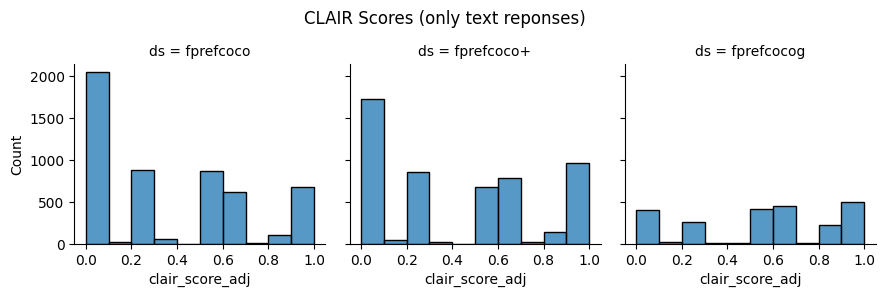

In [541]:
plot = sns.displot(
    df_scores[(~df_scores.is_object_presence_predicted)],
    x="clair_score_adj",
    col="ds",
    binwidth=0.1,
    height=3,
    facet_kws=dict(margin_titles=True),
)
plot.fig.subplots_adjust(top=0.8, bottom=0.2)  # adjust the Figure in rp
plot.fig.suptitle("CLAIR Scores (only text reponses)")

In [531]:
print("samples that need clair score: ", df_scores[df_scores.has_fp_correction & (~df_scores.gt_exist)].shape)
df_scores.clair_score_adj.describe()

samples that need clair score:  (351, 25)


count   351.00
mean      0.40
std       0.37
min       0.00
25%       0.00
50%       0.30
75%       0.70
max       1.00
Name: clair_score_adj, dtype: float64

In [523]:
df_scores[~df_scores.has_fp_correction][output_cols].sort_values("clair_score_adj", ascending=True).head(100)

,is_object_presence_predicted,has_final_score,clair_score,clair_score_adj,pred_sent,sentence,gt_sentence,has_fp_correction,fp_correction
14,False,False,0.00,NaN,"No, there is no banana edge of couch near her arm in the image.",banana edge of couch near her arm,rofl edge of couch near her arm,False,
15,False,False,0.00,NaN,"No, there is no arm couch banana in the image.",arm couch banana,arm couch left,False,
25,False,False,0.00,NaN,"No, there is no elephant green in the image.",elephant green,woman blue,False,
26,False,False,0.00,NaN,"No, there is no elephant wearing orange on the right in the image.",the elephant wearing orange on the right,the woman wearing navy on the right,False,
53,False,False,0.00,NaN,"No, there is no 77 in the image.",77,33,False,
54,False,False,0.00,NaN,"No, there is no 77 in the image.",77,33,False,
82,False,False,0.00,NaN,"No, there is no ref in the image.",ref,ump,False,
83,False,False,0.00,NaN,"No, there is no ref in the image.",ref,ump,False,
84,False,False,0.00,NaN,"No, there is no woman in green near me in the image.",woman in green near you,woman in blue near you,False,
85,False,False,0.00,NaN,"No, there is no green shirt in the image.",green shirt,blue shirt,False,


In [482]:
df_scores[(~df_scores.has_final_score)][output_cols].head(100)

,is_object_presence_predicted,has_final_score,clair_score,clair_score_adj,pred_sent,sentence,gt_sentence,fp_correction


In [552]:
df_scores[(df_scores.ds=="fprefcocog") & (df_scores.clair_score_adj == 0) & ((df_scores.fp_correction.str.contains("pig"))  )].head(100)
# df_scores[(df_scores.ds=="fprefcocog") & (df_scores.clair_score_adj == 0)  ].head(100)

,ds,clair_candidates,clair_reason,clair_reference_set,clair_score,conversation,gt_exist,image_id,pred_exist,pred_sent,...,change_type,ref_gt_sents,img_gt_sents,is_object_presence_predicted,fp_correction,has_fp_correction,is_fp_correction_whitelisted,clair_score_adj,has_final_score,has_candidate
11486,fprefcocog,[ a young girl holding a piece of bread in her hand.],"The candidate phrase describes a young girl holding a piece of bread, while the reference phrases describe boys interacting with their fingers, not holding bread. There is no match.","[a little boy putting finger into the mouth, a boy licking his fingers]",0.00,Analyze the image and verify if there are any referred objects in the image. Yes or no with explanations. Here's an example.,False,278549,False,"No, there is no little girl putting finger into the mouth in the image. The image shows a young girl holding a piece of bread in her hand.",...,main_subject,"[a little boy putting finger into the mouth, a boy licking his fingers]","[a child is holding a piece of bread, the baby in green, a little boy putting finger into the mouth, a boy licking his fingers]",False,a young girl holding a piece of bread in her hand.,True,False,0.00,True,True
11487,fprefcocog,[ a young girl holding a piece of bread in her hand.],"The candidate phrase describes a young girl holding a piece of bread, while the reference phrases describe boys interacting with their fingers. There is no match in gender, action, or object.","[a little boy putting finger into the mouth, a boy licking his fingers]",0.00,Analyze the image and verify if there are any referred objects in the image. Yes or no with explanations. Here's an example.,False,278549,False,"No, there is no boy biting his fingers in the image. The image shows a young girl holding a piece of bread in her hand.",...,NOT_MAIN_SUBJ,"[a little boy putting finger into the mouth, a boy licking his fingers]","[a child is holding a piece of bread, the baby in green, a little boy putting finger into the mouth, a boy licking his fingers]",False,a young girl holding a piece of bread in her hand.,True,False,0.00,True,True
11488,fprefcocog,[ a young girl holding a piece of bread in her hand.],"The candidate phrase describes a young girl holding a piece of bread, while the reference phrases describe boys interacting with their fingers, not holding bread. There is no match.","[a little boy putting finger into the mouth, a boy licking his fingers]",0.00,Analyze the image and verify if there are any referred objects in the image. Yes or no with explanations. Here's an example.,False,278549,False,"No, there is no little girl putting finger into the mouth in the image. The image shows a young girl holding a piece of bread in her hand.",...,main_subject,"[a little boy putting finger into the mouth, a boy licking his fingers]","[a child is holding a piece of bread, the baby in green, a little boy putting finger into the mouth, a boy licking his fingers]",False,a young girl holding a piece of bread in her hand.,True,False,0.00,True,True
11489,fprefcocog,[ a young girl holding a piece of bread in her hand.],"The candidate phrase describes a young girl holding a piece of bread, while the reference phrases describe boys interacting with their fingers. There is no match in gender, action, or object.","[a little boy putting finger into the mouth, a boy licking his fingers]",0.00,Analyze the image and verify if there are any referred objects in the image. Yes or no with explanations. Here's an example.,False,278549,False,"No, there is no boy biting his fingers in the image. The image shows a young girl holding a piece of bread in her hand.",...,NOT_MAIN_SUBJ,"[a little boy putting finger into the mouth, a boy licking his fingers]","[a child is holding a piece of bread, the baby in green, a little boy putting finger into the mouth, a boy licking his fingers]",False,a young girl holding a piece of bread in her hand.,True,False,0.00,True,True
11507,fprefcocog,"[the woman

In [524]:
df_scores[(df_scores.has_final_score)][output_cols].head(100)

,is_object_presence_predicted,has_final_score,clair_score,clair_score_adj,pred_sent,sentence,gt_sentence,has_fp_correction,fp_correction
0,False,True,0.00,0.00,"No, there is no person in a pink shirt in the image. The image only shows a man and a woman sitting at a wooden dining table with a game board, wine glasses, and scissors.",person in pink shirt,person in blue shirt,True,"a man and a woman sitting at a wooden dining table with a game board, wine glasses, and scissors."
1,False,True,0.80,0.80,"No, there is no left kid blowing bubble in the image. The image features a young girl holding a piece of bread in her hand.",left kid blowing bubble,left kid sucking finger,True,a young girl holding a piece of bread in her hand.
2,False,True,0.80,0.80,"No, there is no one with finger in nose in the image. The image shows a young girl holding a piece of bread in her hand.",one with finger in nose,one with finger in mouth,True,a young girl holding a piece of bread in her hand.
3,False,True,0.80,0.80,"No, there is no kid with a toy in the image. The image features a young girl holding a piece of bread in her hand.",kid with toy,kid with food,True,a young girl holding a piece of bread in her hand.
4,False,True,0.70,0.70,"No, there is no banana in front at left in the image. The image features a bowl filled with apples and an orange.",banana in front at left,apple in front at left,True,a bowl filled with apples and an orange.
5,False,True,0.70,0.70,"No, there is no banana in the front on the left in the image. The image features a bowl filled with apples and an orange.",banana in the front on the left,apple in the front on the left,True,a bowl filled with apples and an orange.
6,False,True,0.70,0.70,"No, there is no banana in the image. The image features a bowl filled with apples and an orange.",upper most left side banana,upper most left side apple,True,a bowl filled with apples and an orange.
7,False,True,0.70,0.70,"No, there is no left top banana in the image. The image features a bowl filled with apples and an orange.",left top banana,left top apple,True,a bowl filled with apples and an orange.
8,False,True,0.70,0.70,"No, there is no banana in the image. The bowl contains apples and an orange.",banana left side,apple left side,True,the bowl contains apples and an orange.
9,False,True,0.70,0.70,"No, there is no banana in the image. The bowl contains apples and an orange.",far left banana,far left apple,True,the bowl contains apples and an orange.


# Scoring for "Hollistic (Ours)" Model:

In [291]:
df_scores, df_no_correction, df_noscore = get_clair_scores_lisa(df)

print(
    "df_scores.shape: ",
    df_scores.shape,
    ", df_no_correction.shape: ",
    df_no_correction.shape,
)

# Display
# display(df_no_correction.head(5))
# pd.options.display.float_format = "{:,.2f}".format
# pd.set_option("display.max_colwidth", None)
# pd.set_option("display.max_rows", None)
# display(
#     pd.DataFrame(df_no_correction.groupby(["fp_correction"]).agg(total=("pred_sent", "count")))
#     .reset_index()
#     .sort_values("total", ascending=False)
#     .head(20)
# )

output_cols = [
    "has_final_score",
    "clair_score",
    "clair_score_adj",
    "pred_sent",
    "sentence",
    "gt_sentence",
    "fp_correction",
    # "pred_exist", # ignore this, it's just a simple `is "no" in prediction' that comes from the eval script
]
display(
    pd.DataFrame(
        df_scores.groupby(
            ["ds", "has_final_score", "is_fp_correction_whitelisted"], dropna=False
        ).agg(total=("pred_sent", "count"))
    )
    .reset_index()
    .head(20)
)
print("no scores: ", len(df_noscore))
display(
    pd.DataFrame(
        df_noscore.groupby(
            ["ds", "has_final_score", "is_fp_correction_whitelisted"], dropna=False
        ).agg(total=("pred_sent", "count"))
    )
    .reset_index()
    .head(20)
)

display(
    pd.DataFrame(
        df_scores.groupby(["ds", "has_fp_correction"], dropna=False).agg(
            total=("pred_sent", "count")
        )
    )
    .reset_index()
    .head(20)
)
display(df_noscore[output_cols].sort_values("fp_correction", ascending=False))

print("Final Scores: ", len(df_scores))
display(
    pd.DataFrame(
        df_scores.groupby(["has_seg_token", "ds"], dropna=False).agg(
            clair_score_adj=("clair_score_adj", "mean"),
            clair_score_stdev=("clair_score_adj", "std"),
        )
    )
    .reset_index()
    .head(20)
)

Processing 16907 results
Num pos: 0, num negative: 16907
has_seg_token:6227, NO_seg_token:10680
Found 219 results with no pred_correction
df_fp.shape:  (16907, 25)
df_scores.shape:  (16907, 25) , df_no_correction.shape:  (219, 25)


,ds,has_final_score,is_fp_correction_whitelisted,total
0,fprefcoco,True,False,4891
1,fprefcoco,True,True,1226
2,fprefcoco+,True,False,5106
3,fprefcoco+,True,True,1026
4,fprefcocog,True,False,4187
5,fprefcocog,True,True,471


no scores:  0


,ds,has_final_score,is_fp_correction_whitelisted,total


,ds,has_fp_correction,total
0,fprefcoco,False,3607
1,fprefcoco,True,2510
2,fprefcoco+,False,3417
3,fprefcoco+,True,2715
4,fprefcocog,False,2137
5,fprefcocog,True,2521


,has_final_score,clair_score,clair_score_adj,pred_sent,sentence,gt_sentence,fp_correction


Final Scores:  16907


,has_seg_token,ds,clair_score_adj,clair_score_stdev
0,False,fprefcoco,0.63,0.44
1,False,fprefcoco+,0.61,0.44
2,False,fprefcocog,0.67,0.40
3,True,fprefcoco,0.00,0.00
4,True,fprefcoco+,0.00,0.00
5,True,fprefcocog,0.00,0.00


In [310]:
display(
    pd.DataFrame(
        df_scores[(~df_scores.has_seg_token)]
        .groupby(["ds"], dropna=False)
        .agg(
            clair_score_adj=("clair_score_adj", "mean"),
            clair_score_stdev=("clair_score_adj", "std"),
        )
    )
    .reset_index()
    .head(20)
)

,ds,clair_score_adj,clair_score_stdev
0,fprefcoco,0.63,0.44
1,fprefcoco+,0.61,0.44
2,fprefcocog,0.67,0.40


/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

Text(0.5, 0.98, 'CLAIR Scores (including False [SEG] Responses)')

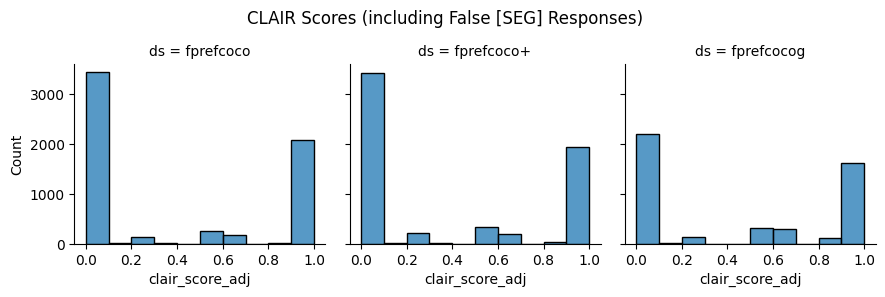

In [308]:
plot = sns.displot(
    df_scores,
    x="clair_score_adj",
    col="ds",
    binwidth=0.1,
    height=3,
    facet_kws=dict(margin_titles=True),
)
plot.fig.subplots_adjust(top=0.8, bottom=0.2)  # adjust the Figure in rp
plot.fig.suptitle("CLAIR Scores (including False [SEG] Responses)")

/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gbiamby/mambaforge/envs/geo_llm_ret/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

Text(0.5, 0.98, 'CLAIR Scores (only text reponses)')

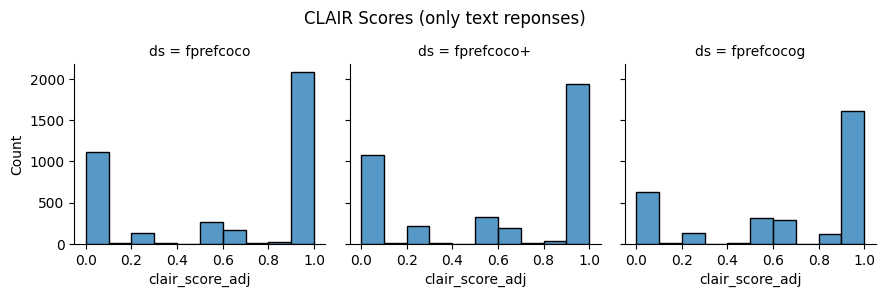

In [306]:
plot = sns.displot(
    df_scores[(~df_scores.has_seg_token)],
    x="clair_score_adj",
    col="ds",
    binwidth=0.1,
    height=3,
    facet_kws=dict(margin_titles=True),
)
plot.fig.subplots_adjust(top=0.8, bottom=0.2)  # adjust the Figure in rp
plot.fig.suptitle("CLAIR Scores (only text reponses)")